## Q.1 Variants of Backprop for visualizing CNNs

#### Importing important libraries

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

In [5]:
from PIL import Image
from torchvision import transforms

# Define transformations for input image
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [6]:
# Load input image
original_img1 = Image.open('img/i1.jpg')
original_img2 = Image.open('img/i2.jpg')
original_img3 = Image.open('img/i3.jpg')
original_img4 = Image.open('img/i4.jpg')
original_img5 = Image.open('img/i5.jpg')
# Apply transformations
transformed_img1 = transform(original_img1)
transformed_img2 = transform(original_img2)
transformed_img3 = transform(original_img3)
transformed_img4 = transform(original_img4)
transformed_img5 = transform(original_img5)

def unsque(img):
    # Add batch dimension to input image
    img = img.unsqueeze(0)
    img.requires_grad=True
    return img
img1=unsque(transformed_img1)
img2=unsque(transformed_img2)
img3=unsque(transformed_img3)
img4=unsque(transformed_img4)
img5=unsque(transformed_img5)


## Vanilla Backpropagation

In [7]:
def Vanilla_bacprop(img):
    global input_grad
    # Define hook function to save gradient
    def save_gradient(a,grads_in,grads_out):
        global input_grad
        input_grad = grads_in[0]

    # Seting model to evaluation mode
    resnet50.eval()

    # Defining hook to save gradient of first layer
    target_layer = list(resnet50._modules.items())[0][1]
    hook_handle = target_layer.register_full_backward_hook(save_gradient)
    
    # Forward pass through model
    output = resnet50(img)

    # Extracting class number of the image
    _, predicted = torch.max(output.data, 1)

    # Calculating gradient of output with respect to input
    output[0,predicted].backward()
    input_grad= input_grad.squeeze(0)

    (input_grad.shape)
    input_grad=torch.permute(input_grad,(1,2,0))
    return input_grad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


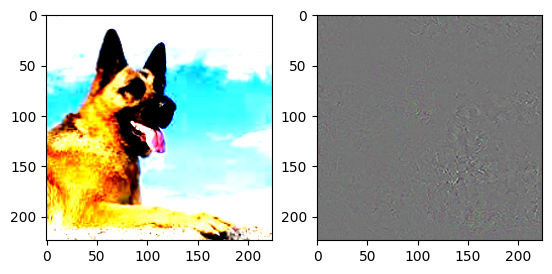

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


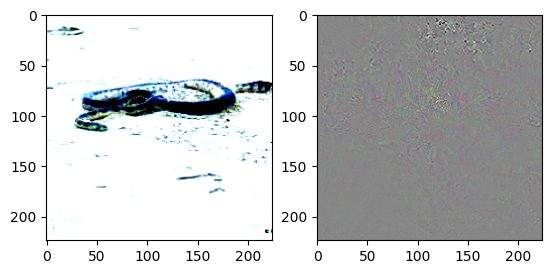

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


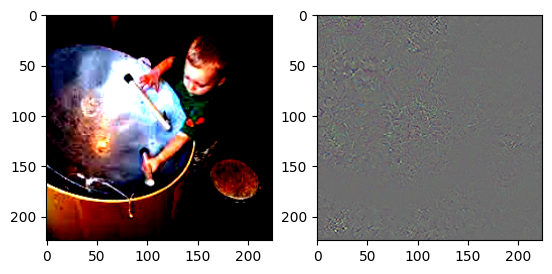

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


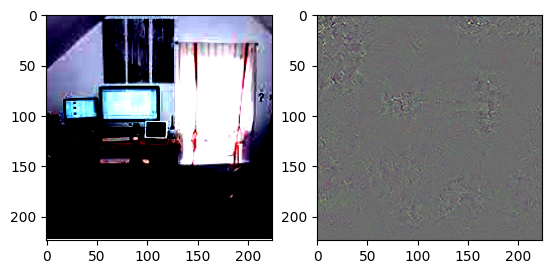

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


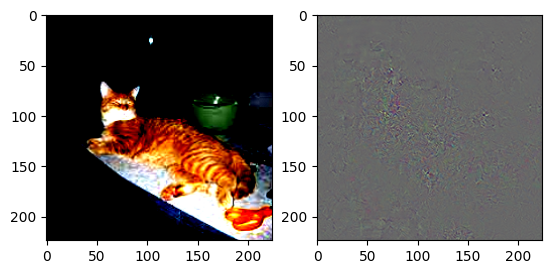

In [8]:
# Function for normalization
def norm(arr):
    temp = arr - torch.min(arr)
    return temp/torch.max(temp)

# Calling vanilla backpropagation
result1=Vanilla_bacprop(img1)
result2=Vanilla_bacprop(img2)
result3=Vanilla_bacprop(img3)
result4=Vanilla_bacprop(img4)
result5=Vanilla_bacprop(img5)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img1,(1,2,0)))
ax2.imshow(norm(result1))
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img2,(1,2,0)))
ax2.imshow(norm(result2))
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img3,(1,2,0)))
ax2.imshow(norm(result3))
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img4,(1,2,0)))
ax2.imshow(norm(result4))
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img5,(1,2,0)))
ax2.imshow(norm(result5))
plt.show()

## Guided-back-propagation

In [9]:
def relu_mod_hook(module, grad_input, grad_output):
    # Replaceing negative gradients with 0
    mod_grad_input = grad_input[0].clamp(min=0.0)
    # Passing only positive gradients
    new_grad_input = torch.where(grad_output[0] > 0, mod_grad_input, torch.zeros_like(grad_input[0]))
    return (new_grad_input,)

In [10]:
# Guided backpropagation
def Guid_bacprop(img):

    # finding positions of relu
    relu_hook_list=[]
    for name, module in resnet50.named_modules():
        if isinstance(module, nn.ReLU):
            relu_hook_list.append(module.register_backward_hook(relu_mod_hook))
            
    global input_grad
    # Seting model to evaluation mode
    resnet50.eval()

    # Forward pass through model
    output = resnet50(img)

    # Calculating gradient of output with respect to input
    output[0, 235].backward()
    for i in relu_hook_list:
        i.remove()
    input_grad= input_grad.squeeze(0)

    (input_grad.shape)
    input_grad=torch.permute(input_grad,(1,2,0))
    return input_grad

C:\Users\arisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


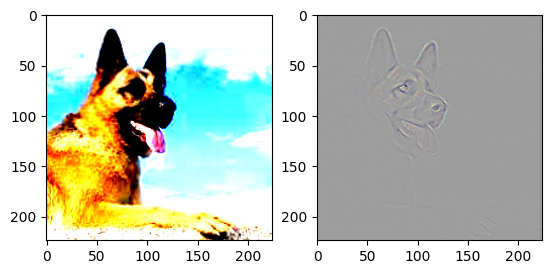

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


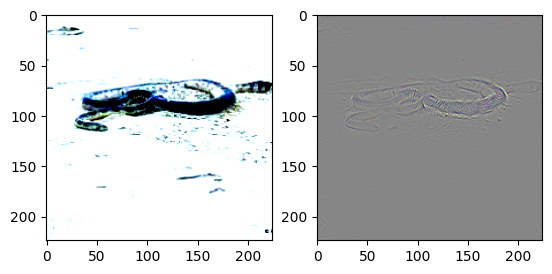

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


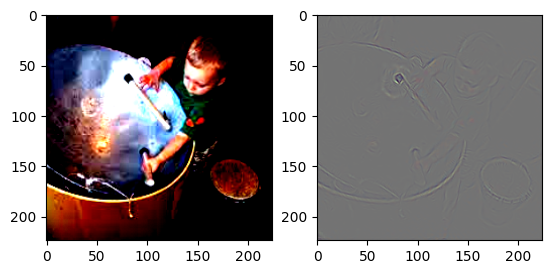

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


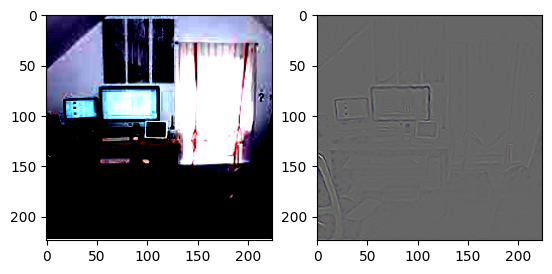

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


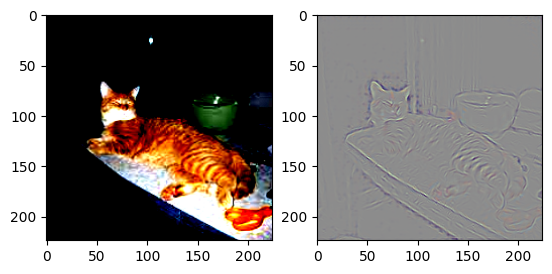

In [11]:
# Calling guided backpropo function and plotting image
result1=Guid_bacprop(img1)
result2=Guid_bacprop(img2)
result3=Guid_bacprop(img3)
result4=Guid_bacprop(img4)
result5=Guid_bacprop(img5)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img1,(1,2,0)))
ax2.imshow(norm(result1))
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img2,(1,2,0)))
ax2.imshow(norm(result2))
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img3,(1,2,0)))
ax2.imshow(norm(result3))
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img4,(1,2,0)))
ax2.imshow(norm(result4))
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img5,(1,2,0)))
ax2.imshow(norm(result5))
plt.show()

## Class Activation Map

In [12]:
def CAM(img):
    global output_grad
    def save_output_gradient(a,grads_in,grads_out):
        global output_grad
        output_grad = grads_out[0]
    resnet50.eval()

    # Choosing 3rd convolution of 4th layer of model
    required_layer = resnet50.layer4[-1].conv3
    hook = required_layer.register_forward_hook(save_output_gradient)

    output = resnet50(img)
    _, predicted = torch.max(output.data, 1)

    # Squeezing and reshaping of output gradient of chossen layer
    output_grad = output_grad.squeeze(0)
    output_grad = output_grad.reshape(2048,49)

    # calculating weight associated with the predicted label
    weights=resnet50.fc.weight
    weights=weights[predicted]

    # taking dot product of weights and output gradient 
    res=weights@output_grad
    res=res.reshape(7,7)
    res=res.detach().numpy()

    # Converting result into numpy for showing image
    res_np=np.array(res)
    return cv2.resize(res_np, (224,224))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


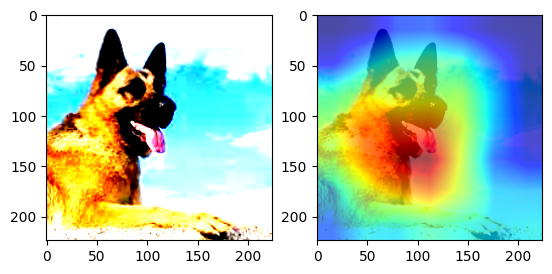

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


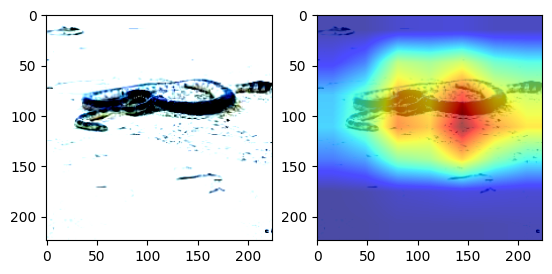

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


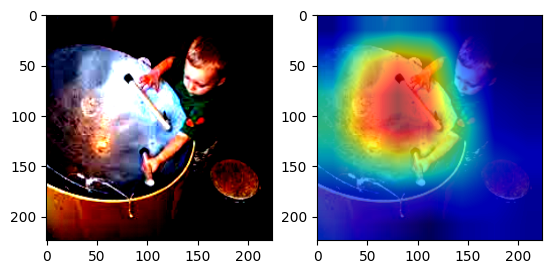

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


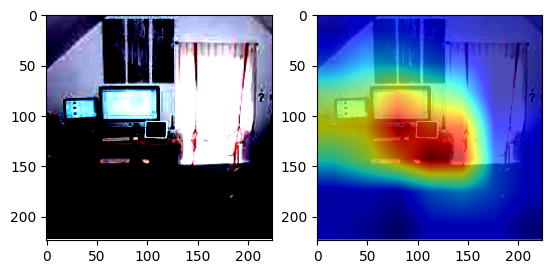

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


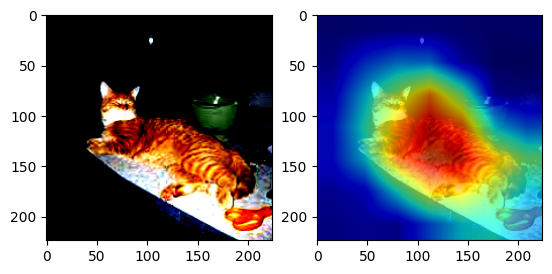

In [13]:
# Calling class activation map function
result1=CAM(img1)
result2=CAM(img2)
result3=CAM(img3)
result4=CAM(img4)
result5=CAM(img5)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img1,(1,2,0)))
ax2.imshow(result1,cmap='jet')
ax2.imshow(torch.permute(transformed_img1,(1,2,0)),alpha=0.3)
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img2,(1,2,0)))
ax2.imshow(result2,cmap='jet')
ax2.imshow(torch.permute(transformed_img2,(1,2,0)),alpha=0.3)
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img3,(1,2,0)))
ax2.imshow(result3,cmap='jet')
ax2.imshow(torch.permute(transformed_img3,(1,2,0)),alpha=0.3)
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img4,(1,2,0)))
ax2.imshow(result4,cmap='jet')
ax2.imshow(torch.permute(transformed_img4,(1,2,0)),alpha=0.3)
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(torch.permute(transformed_img5,(1,2,0)))
ax2.imshow(result5,cmap='jet')
ax2.imshow(torch.permute(transformed_img5,(1,2,0)),alpha=0.3)
plt.show()

## Guided Grad-CAM

In [14]:
def global_avg_pool(img):
    img=np.array(img)
    shape=np.shape(img)
    res=[]
    for k in range(shape[0]):
        res.append(np.mean(img[k,:,:]))
    res=torch.tensor(res).reshape(1,-1)
    return res

def ReLU(img):
    return torch.max(img,torch.tensor(0))

In [15]:
def guid_grad_CAM(img):
    global grads_o
    global grads_i
    grads_o=[]
    grads_i=[]
    # Define hook function to save gradient
    def save_output_gradient(a,grads_in,grads_out):
        global grads_o
        grads_o.append(grads_out[0])
    # Define hook function to save gradient
    def save_output(a,_in,_out):
        global grads_i
        grads_i.append(_in[0])
        # print(len(grads_i))
    
    # Set model to evaluation mode
    resnet50.eval()

    # Hook layer
    target_layer = resnet50.layer4[-1].relu
    hook_handle1 = target_layer.register_backward_hook(save_output_gradient)
    hook_handle2 = target_layer.register_forward_hook(save_output)

    # Forward pass through model
    output = resnet50(img)
    _, predicted = torch.max(output.data, 1)

    grads_i= grads_i[2].squeeze(0)

    resnet50.zero_grad()
    output[0, predicted].backward()
    hook_handle2.remove()
    hook_handle1.remove()
    grads_o= grads_o[0].squeeze(0)
    grads_o=global_avg_pool(grads_o)

    grads_i=grads_i.reshape(2048,49)

    res=grads_o@grads_i
    res=res.squeeze()
    res= res.reshape(7,7)
    res=res.detach().numpy()
    res=torch.tensor(res)
    # print(res)
    res=ReLU(res)
    # plt.imshow(res)
    res_np=np.array(res)

    return res_np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


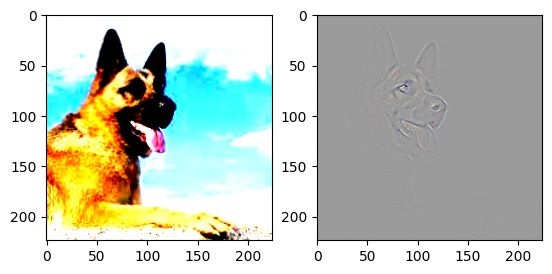

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


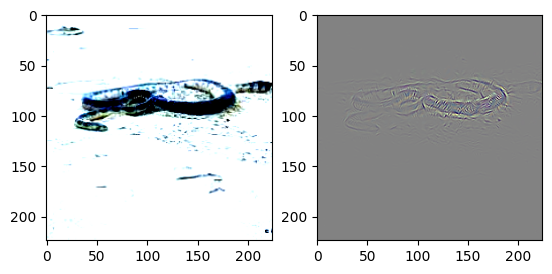

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


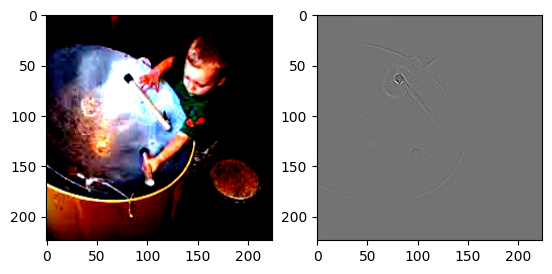

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


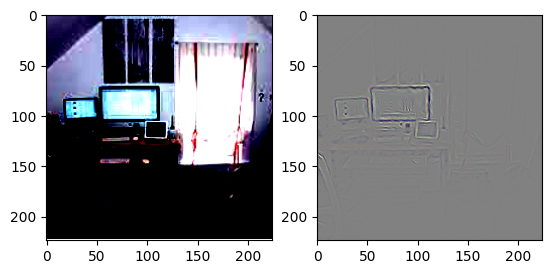

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


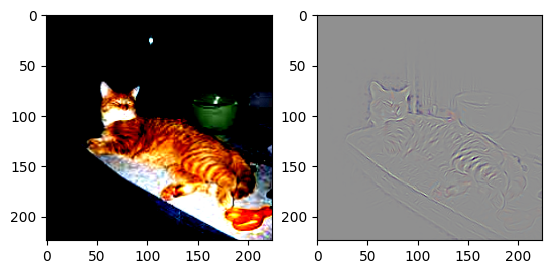

In [16]:
def print_im(img,transformed_img):
    result=guid_grad_CAM(img)
    result= cv2.resize(result, (224,224))
    result=torch.tensor(result)
    result2=Guid_bacprop(img)
    res = torch.permute(result2, (2,0,1))*result

    fig,(ax1,ax2)=plt.subplots(1,2)
    ax1.imshow(torch.permute(transformed_img,(1,2,0)))
    ax2.imshow(norm(torch.permute(res, (1,2,0))), cmap = 'jet', interpolation = 'none')
    plt.show()

    return

print_im(img1,transformed_img1)
print_im(img2,transformed_img2)
print_im(img3,transformed_img3)
print_im(img4,transformed_img4)
print_im(img5,transformed_img5)

## Q2- SGD Update rule variations

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Given function
def f(x,y):
    return 10*x**2 +y**2

In [19]:
# function derivative with respect to x
def f_x(x,y):
    return 20*x

# function derivative with respect to y
def f_y(x,y):
    return 2*y

### Sochastic Gradient Decent

In [20]:
x=-1                    # Initial x coordinate
y=1.5                    # Initial y coordinate
lr=0.07                  # learning rate
x1=[x]
y1=[y]
z1=[f(x,y)]
# print(f(x,y))
for i in range(50):
    x=x-lr*f_x(x,y)
    y=y-lr*f_y(x,y)
    x1.append(x)
    y1.append(y)
    z1.append(f(x,y))

# functional value after converging
print(f(x,y))   

6.339100577997856e-07


### SGD + Momentum

In [21]:
x=-1                    # Initial x coordinate
y=1.5                    # Initial y coordinate
v_x=0
v_y=0
lr=0.01
rho=0.8
# i=0
x2=[x]
y2=[y]
z2=[f(x,y)]

for i in range(50):
    v_x = rho*v_x + f_x(x,y)
    v_y = rho*v_y + f_y(x,y)
    x = x-lr*v_x
    y = y-lr*v_y
    x2.append(x)
    y2.append(y)
    z2.append(f(x,y))

# functional value after converging
print(f(x,y))

3.6054982399983015e-05


### Nesterov Momentum

In [22]:
x=-1                    # Initial x coordinate
y=1.5                    # Initial y coordinate
v_x=0
v_y=0
lr=0.03
rho=0.03
# i=0
x3=[x]
y3=[y]
z3=[f(x,y)]
for i in range(50):
    v_x = rho*v_x + f_x(x+rho*v_x,y)
    v_y = rho*v_y + f_y(x,y+rho*v_y)
    x = x-lr*v_x
    y = y-lr*v_y
    x3.append(x)
    y3.append(y)
    z3.append(f(x,y))

# functional value after converging
print(f(x,y))

0.0023704429552196806


### Adaptive GD

In [23]:
x=-1                    # Initial x coordinate
y=1.5                    # Initial y coordinate
s_x=0
s_y=0
lr=0.1
# i=0
x4=[x]
y4=[y]
z4=[f(x,y)]

for i in range(50):
    s_x += f_x(x,y)**2
    s_y += f_y(x,y)**2
    x -= lr*f_x(x,y)/np.sqrt(s_x)
    y -= lr*f_y(x,y)/np.sqrt(s_y)
    x4.append(x)
    y4.append(y)
    z4.append(f(x,y))

# functional value after converging
print(f(x,y))

0.4196982453877549


### RMS Prop

In [24]:
x=-1                    # Initial x coordinate
y=1.5                    # Initial y coordinate
s_x=0
s_y=0
lr=0.05
rho=0.1
# i=0
x5=[x]
y5=[y]
z5=[f(x,y)]

for i in range(50):
    s_x = rho*s_x + (1-rho)*f_x(x,y)**2
    s_y = rho*s_y + (1-rho)*f_y(x,y)**2
    x -= lr*f_x(x,y)/np.sqrt(s_x)
    y -= lr*f_y(x,y)/np.sqrt(s_y)
    x5.append(x)
    y5.append(y)
    z5.append(f(x,y))

# functional value after converging
print(f(x,y))

0.0068750008873515785


### Plotting

In [25]:
!mkdir images
import matplotlib as cm
lst=['sgd','sgdM','hd','hdd','djd']
x=np.linspace(-2,2,1000)
y=np.linspace(-2,2,1000)
x,y=np.meshgrid(x,y)
z=f(x,y)
plt.figure(1)
ax=plt.axes(projection="3d")
ax.plot_surface(x,y,z,alpha=0.5,color="w")


for i in range(50):
    plt.figure(1)
    if i==0:
        ax.plot(x1[:i],y1[:i],z1[:i],color='g',lw=1, label='SGD')
        ax.plot(x2[:i],y2[:i],z2[:i],color='b',lw=1, label='SGD+momentum')
        ax.plot(x3[:i],y3[:i],z3[:i],color='r',lw=1, label='Nestrove')
        ax.plot(x4[:i],y4[:i],z4[:i],color='k',lw=1, label='Adaptive GD')
        ax.plot(x5[:i],y5[:i],z5[:i],color='y',lw=1, label='RMS prop')
    else:
        ax.plot(x1[:i],y1[:i],z1[:i],color='g',lw=1)
        ax.plot(x2[:i],y2[:i],z2[:i],color='b',lw=1)
        ax.plot(x3[:i],y3[:i],z3[:i],color='r',lw=1)
        ax.plot(x4[:i],y4[:i],z4[:i],color='k',lw=1)
        ax.plot(x5[:i],y5[:i],z5[:i],color='y',lw=1)
    plt.legend(loc='best')
    plt.savefig(f'images/{i:003}'+'.png',dpi=100,facecolor='white')
plt.close()

import imageio.v2
images = []
for i in range(0,50):
    images.append(imageio.v2.imread(f'images/{i:003}'+'.png'))
imageio.mimsave('saved.gif',images)

A subdirectory or file images already exists.
